### Import modules

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import dask.distributed
from distributed.diagnostics.progressbar import progress
import bokeh
import time
import numpy as np
import pandas as pd
import scipy
import os
import cv2
import matplotlib.pyplot as plt

In [7]:
max_workers = os.cpu_count()
print(f'{max_workers} cores on local machine')
print( '─ ' * 60)

print("Check Active Memory Management is on -->", dask.config.get("distributed.scheduler.active-memory-manager")) 

4 cores on local machine
─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ 
Check Active Memory Management is on --> {'start': True, 'interval': '2s', 'policies': [{'class': 'distributed.active_memory_manager.ReduceReplicas'}]}


In [8]:
local_cluster = dask.distributed.LocalCluster(n_workers=max_workers, 
                                                threads_per_worker=4 
                                                )

In [9]:
client = dask.distributed.Client(local_cluster)

In [10]:
def return_subfolders(parent):
    '''list of all subfolders'''
    for folder in os.listdir(parent):
        # exclude non-folders and hidden files
        if not folder.startswith('.') and os.path.isdir(os.path.join(path_train, folder)) : 
            yield folder

def load_from_directory(sub_path):
    imgs_array = []
    for  img in os.listdir(sub_path):
        image_path = sub_path + "/" +img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(128,128))
        imgs_array.append(img_arr)
    return imgs_array



In [12]:
path_train = "data/train_another"
path_val = "data/validation_another"
path_test = "data/test"

futures = []

for folder_path in [path_train, path_val, path_test]:
    for folder in return_subfolders(folder_path):
        sub_path = folder_path + "/" + folder
        future = client.submit(load_from_directory, sub_path)
        futures.append(future)

In [14]:
progress(futures)

VBox()

In [16]:
futures

[<Future: finished, type: list, key: load_from_directory-215c780703e853cc4c1243c574a37ff7>,
 <Future: finished, type: list, key: load_from_directory-9da17a2fba5ba3eda186fe76e70c86b6>,
 <Future: finished, type: list, key: load_from_directory-70dc728503dc29596e6d425c5df48308>,
 <Future: finished, type: list, key: load_from_directory-7a43c1be49254b63402e29cf318ffbe1>,
 <Future: finished, type: list, key: load_from_directory-4de277f6944539eb2c2a0ef8617b9a72>,
 <Future: finished, type: list, key: load_from_directory-e99075911f3d39bd82813a1ba5cb565b>]

In [15]:
res = client.gather(futures)

x_train = res[0] + res[1]
x_val = res[2] + res[3]
x_test = res[4] + res[5]

print(f"{len(x_train)} training samples")
print(f"{len(x_val)} validation samples")
print(f"{len(x_test)} testing samples")

10000 training samples
2000 validation samples
2000 testing samples


Normalization

In [17]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
BATCH_SIZE = 64

train_set = train_datagen.flow_from_directory(path_train,
                                                 target_size = (128, 128),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

val_set = val_datagen.flow_from_directory(path_val,
                                                 target_size = (128, 128),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(path_test,
                                                 target_size = (128, 128),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

print(train_set.class_indices)
print(val_set.class_indices)
print(test_set.class_indices)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
{'damage': 0, 'no_damage': 1}
{'damage': 0, 'no_damage': 1}
{'damage': 0, 'no_damage': 1}


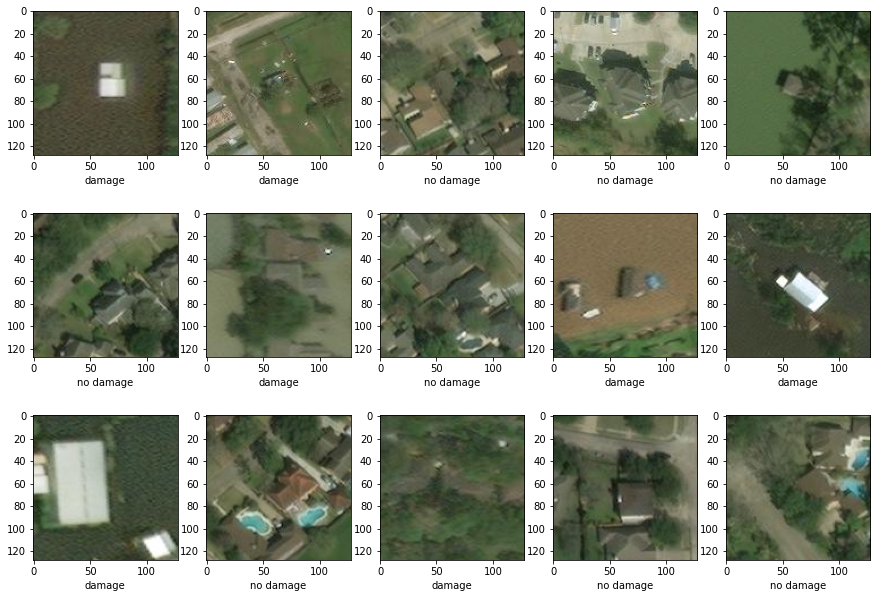

In [20]:
first_batch_images = train_set[0][0]  
first_batch_labels = train_set[0][1]

plt.figure(figsize=(15,18))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(first_batch_images[i])
    plt.xlabel('damage' if first_batch_labels[i]==0 else 'no damage')
plt.show()

In [21]:
base_model = Sequential()
base_model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', input_shape=(128, 128, 3)))
base_model.add(MaxPooling2D((2, 2)))
base_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2, 2)))
base_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))

base_model.add(Flatten())
base_model.add(Dense(64, activation='relu'))
base_model.add(Dense(1))

In [22]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

In [23]:
base_model.compile(
                    loss='binary_crossentropy',
                    optimizer="Nadam",
                    metrics=['accuracy']
                    )

In [24]:
custom_cbacks = [
    EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5), 
]

In [25]:
history = base_model.fit(
                            train_set,
                            validation_data=val_set,
                            epochs=10,
                            batch_size=BATCH_SIZE,
                            callbacks=custom_cbacks,
                            shuffle=True)

Epoch 1/10
133/157 [========================>.....] - ETA: 43s - loss: 7.6282 - accuracy: 0.4993

2022-05-19 15:21:00,731 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "c:\Users\rgris\projects\venvs\venv_hurricane\lib\site-packages\tornado\websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "c:\Users\rgris\projects\venvs\venv_hurricane\lib\site-packages\tornado\web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "c:\Users\rgris\projects\venvs\venv_hurricane\lib\site-packages\bokeh\server\views\ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


157/157 [==============================] - 321s 2s/step - loss: 7.6185 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 2/10
157/157 [==============================] - 245s 2s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/10
157/157 [==============================] - 243s 2s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/10
157/157 [==============================] - 226s 1s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/10
157/157 [==============================] - 212s 1s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 6/10
157/157 [==============================] - 234s 1s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 7/10
157/157 [==============================] - 232s 1s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 8/10